,coef
speed,1.35
accel_mag,0.85
speed_roll_mean,0.20
speed_roll_std,0.10
ping_ms,-0.05
action,0.03


Intercept: -2.1500 | Decision threshold: 0.85


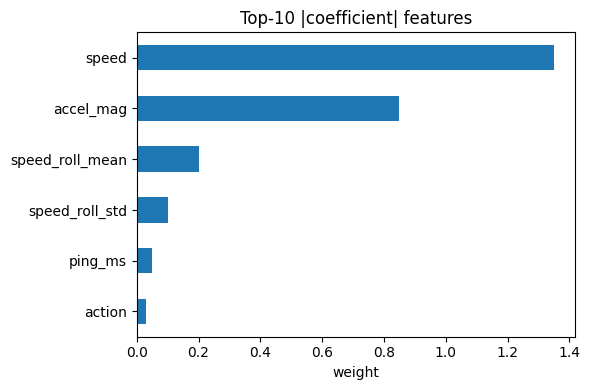

In [76]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If eval_visuals.ipynb is inside notebooks/, keep this path:
MODEL_PATH = "../models/logreg_export.json"

if not Path(MODEL_PATH).exists():
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}\nCWD: {os.getcwd()}")

with open(MODEL_PATH, "r") as f:
    mj = json.load(f)

FEATURES  = list(mj["features"])
COEF      = np.array(mj["coef"], dtype=float)
INTERCEPT = float(mj["intercept"])
THR       = float(mj.get("decision_threshold", 0.5))

coef_s = pd.Series(COEF, index=FEATURES).sort_values(key=np.abs, ascending=False)
display(coef_s.to_frame("coef"))
print(f"Intercept: {INTERCEPT:.4f} | Decision threshold: {THR:.2f}")

# Optional plot
plt.figure(figsize=(6,4))
coef_s.abs().sort_values(ascending=False).head(10).iloc[::-1].plot(kind="barh")
plt.title("Top-10 |coefficient| features")
plt.xlabel("weight")
plt.tight_layout()
plt.show()


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tel = pd.read_csv("../data/telemetry.csv")
ev  = pd.read_csv("../data/eval.csv")

assert set(["tick","speed","ml_prob","ml_pred","rule_alert","cheat_flag"]).issubset(ev.columns)
print(ev.head())
print("Rows:", len(ev))



   tick     speed   ml_prob  ml_pred  rule_alert  cheat_flag
0     0  0.753942  0.035951        0           0           0
1     1  2.453866  0.981182        0           0           0
2     2  2.070462  0.981315        0           0           0
3     3  0.509776  0.170726        0           0           0
4     4  0.428370  0.056498        0           0           0
Rows: 100


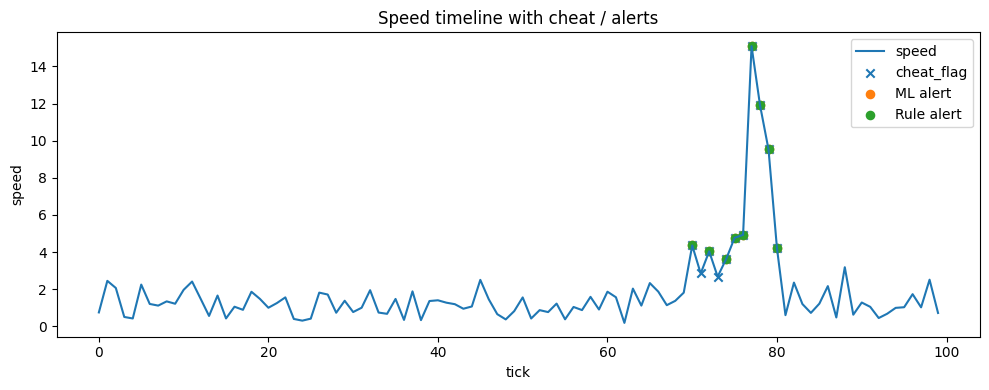

In [78]:
plt.figure(figsize=(10,4))
plt.plot(ev["tick"], ev["speed"], label="speed")
plt.scatter(ev.loc[ev["cheat_flag"]==1,"tick"],
            ev.loc[ev["cheat_flag"]==1,"speed"],
            marker='x', label="cheat_flag")
plt.scatter(ev.loc[ev["ml_pred"]==1,"tick"],
            ev.loc[ev["ml_pred"]==1,"speed"],
            label="ML alert", s=35)
plt.scatter(ev.loc[ev["rule_alert"]==1,"tick"],
            ev.loc[ev["rule_alert"]==1,"speed"],
            label="Rule alert", s=35)
plt.legend(); plt.title("Speed timeline with cheat / alerts")
plt.xlabel("tick"); plt.ylabel("speed"); plt.tight_layout()
plt.show()


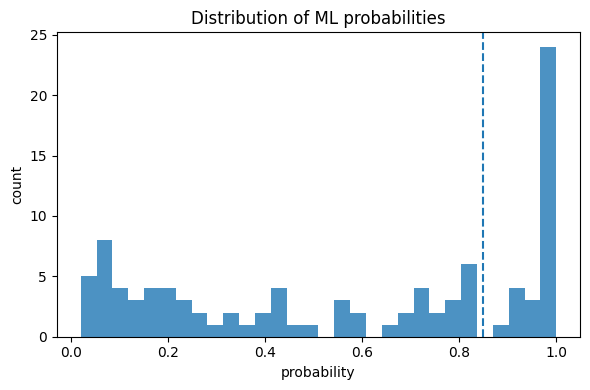

In [79]:
thr = 0.85  # keep in sync with logreg_export.json
plt.figure(figsize=(6,4))
plt.hist(ev["ml_prob"], bins=30, alpha=0.8)
plt.axvline(thr, linestyle='--')
plt.title("Distribution of ML probabilities")
plt.xlabel("probability"); plt.ylabel("count"); plt.tight_layout()
plt.show()


PR-AUC=0.986  ROC-AUC=0.998


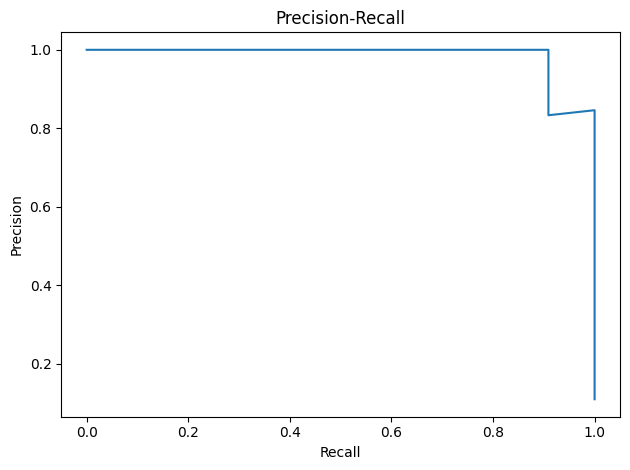

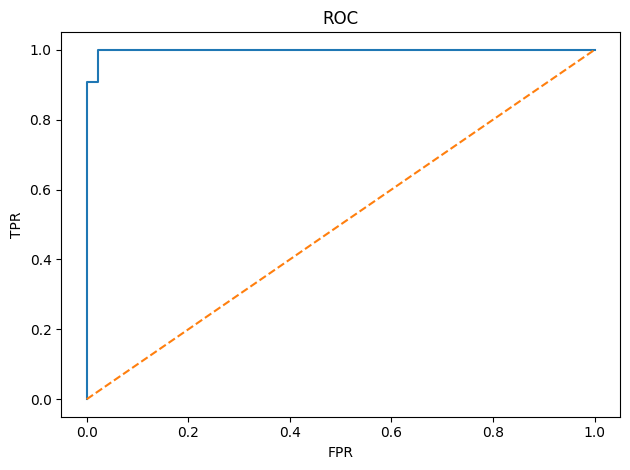

In [80]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score, roc_auc_score, roc_curve, precision_recall_curve

y_true = ev["cheat_flag"].values
scores = ev["ml_prob"].values

precisions, recalls, thr = precision_recall_curve(y_true, scores)
ap = average_precision_score(y_true, scores)
fpr, tpr, _ = roc_curve(y_true, scores)
roc = roc_auc_score(y_true, scores)

print(f"PR-AUC={ap:.3f}  ROC-AUC={roc:.3f}")

plt.figure(); plt.plot(recalls, precisions)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall"); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.tight_layout(); plt.show()


In [81]:
best = None
for t in np.linspace(0.2, 0.95, 31):
    pred = (scores >= t).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_true, pred, average='binary', zero_division=0)
    if best is None or f > best[0]:
        best = (f, p, r, t)
print("Best F1 on this run -> F1=%.3f, P=%.3f, R=%.3f at thr=%.2f" % best)


Best F1 on this run -> F1=0.595, P=0.423, R=1.000 at thr=0.95


ML ROC-AUC: 0.9979570990806945
ML PR-AUC : 0.986013986013986
Rules: precision=1.00 recall=0.82
ML(thr): precision=1.00 recall=0.82


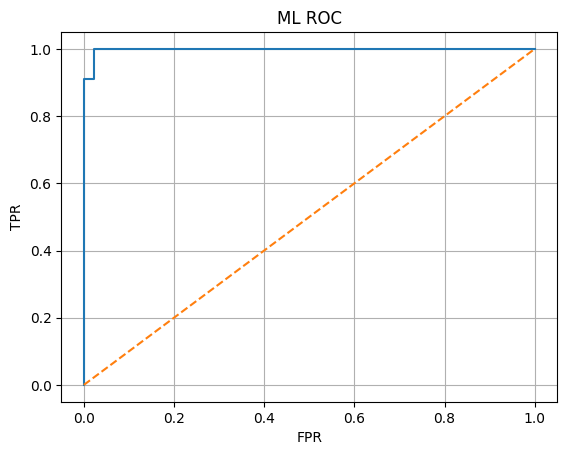

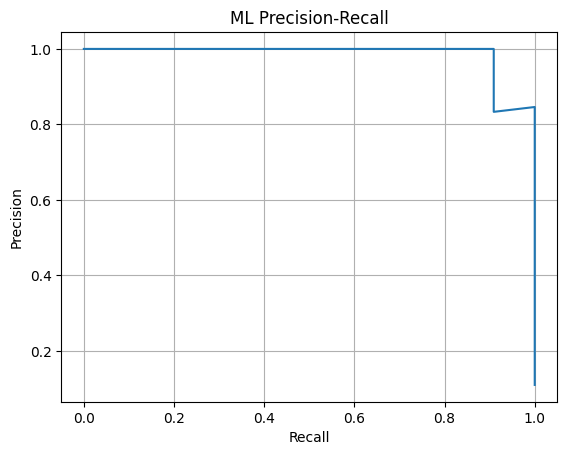

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

hyb = pd.read_csv("../data/eval_hybrid.csv")   # has ml_prob, ml_pred, rule_alert, cheat_flag
rul = pd.read_csv("../data/eval_rules.csv")    # if you ran rules-only, else reuse hyb

y = hyb["cheat_flag"].values.astype(int)
ml_prob = hyb["ml_prob"].values
ml_pred = hyb["ml_pred"].values
rule_pred = hyb["rule_alert"].values

# ROC / PR for ML
fpr, tpr, _ = roc_curve(y, ml_prob)
prec, rec, _ = precision_recall_curve(y, ml_prob)
print("ML ROC-AUC:", roc_auc_score(y, ml_prob))
print("ML PR-AUC :", average_precision_score(y, ml_prob))

plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title("ML ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(True)
plt.figure(); plt.plot(rec, prec); plt.title("ML Precision-Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True)

# Discrete points for Rules and current ML threshold
def metrics_from_binary(pred, truth):
    TP = np.sum((pred==1)&(truth==1))
    FP = np.sum((pred==1)&(truth==0))
    FN = np.sum((pred==0)&(truth==1))
    TN = np.sum((pred==0)&(truth==0))
    precision = TP/(TP+FP) if (TP+FP) else 0
    recall    = TP/(TP+FN) if (TP+FN) else 0
    return TP,FP,FN,TN,precision,recall

tp,fp,fn,tn,p_m,r_m = metrics_from_binary(ml_pred, y)
tr,fr,frn,tnr,p_r,r_r = metrics_from_binary(rule_pred, y)
print(f"Rules: precision={p_r:.2f} recall={r_r:.2f}")
print(f"ML(thr): precision={p_m:.2f} recall={r_m:.2f}")


,thr,precision,recall,f1,TP,FP,FN,TN
0,0.500000,0.196429,1.0,0.328358,11,45,0,44
1,0.516897,0.200000,1.0,0.333333,11,44,0,45
2,0.533793,0.200000,1.0,0.333333,11,44,0,45
3,0.550690,0.203704,1.0,0.338462,11,43,0,46
4,0.567586,0.211538,1.0,0.349206,11,41,0,48


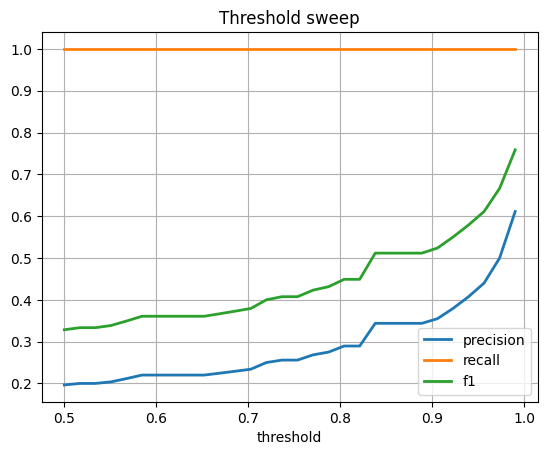

Best by F1: {'thr': 0.99, 'precision': 0.6111111111111112, 'recall': 1.0, 'f1': 0.7586206896551725, 'TP': 11.0, 'FP': 7.0, 'FN': 0.0, 'TN': 82.0}


In [83]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

hyb = pd.read_csv("../data/eval_hybrid.csv")  # adjust path if notebook sits elsewhere
y = hyb["cheat_flag"].astype(int).values
probs = hyb["ml_prob"].astype(float).values

def sweep_thresholds(probs, truth, steps=np.linspace(0.5, 0.99, 30)):
    rows = []
    for t in steps:
        pred = (probs >= t).astype(int)
        TP = np.sum((pred==1)&(truth==1)); FP = np.sum((pred==1)&(truth==0))
        FN = np.sum((pred==0)&(truth==1)); TN = np.sum((pred==0)&(truth==0))
        precision = TP/(TP+FP) if (TP+FP) else 0
        recall    = TP/(TP+FN) if (TP+FN) else 0
        f1 = 2*precision*recall/(precision+recall) if (precision+recall) else 0
        rows.append((float(t), precision, recall, f1, TP, FP, FN, TN))
    return pd.DataFrame(rows, columns=["thr","precision","recall","f1","TP","FP","FN","TN"])

sweep = sweep_thresholds(probs, y)
display(sweep.head())

plt.figure()
plt.plot(sweep["thr"], sweep["precision"], label="precision", linewidth=2)
plt.plot(sweep["thr"], sweep["recall"], label="recall", linewidth=2)
plt.plot(sweep["thr"], sweep["f1"], label="f1", linewidth=2)
plt.xlabel("threshold"); plt.legend(); plt.grid(True); plt.title("Threshold sweep");
plt.show()

best = sweep.iloc[sweep["f1"].idxmax()]
best_thr = float(best["thr"])
print("Best by F1:", best.to_dict())


In [84]:
import pandas as pd

df = pd.read_csv("../data/eval_hybrid.csv")  # adjust one or two dots until it works
print(df[["ml_prob","ml_pred","rule_alert","cheat_flag"]].head(15))
print("ml_pred==1 count:", (df.ml_pred==1).sum())
print("rule_alert==1 count:", (df.rule_alert==1).sum())


     ml_prob  ml_pred  rule_alert  cheat_flag
0   0.035951        0           0           0
1   0.981182        0           0           0
2   0.981315        0           0           0
3   0.170726        0           0           0
4   0.056498        0           0           0
5   0.970862        0           0           0
6   0.707580        0           0           0
7   0.260192        0           0           0
8   0.788236        0           0           0
9   0.440579        0           0           0
10  0.834179        0           0           0
11  0.988387        0           0           0
12  0.900114        0           0           0
13  0.248603        0           0           0
14  0.831655        0           0           0
ml_pred==1 count: 9
rule_alert==1 count: 9
